In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import datetime
import matplotlib.cm as cm
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from IPython.core.debugger import set_trace



# Load and cleaning data

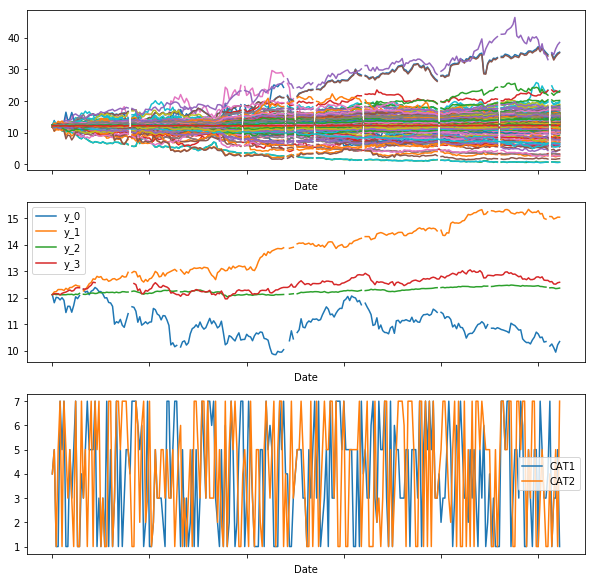


Number of stocks whose price are NaN on these dates:
Date
2015-01-06    440
2015-01-10      1
2015-01-20      1
2015-02-28      1
2015-03-26      7
2015-03-27    439
2015-04-18      1
2015-04-28    439
2015-05-05    439
2015-05-19    439
2015-06-23    439
2015-08-15    439
2015-08-18      1
2015-08-19      1
2015-09-29    439
2015-10-07      1
2015-11-04    443
dtype: int64

Stocks that still have NaN after dropping the bad dates
x_72     6
x_438    1
dtype: int64

Shape of x after cleaning: (252, 442)


In [2]:
x = pd.read_csv('X.csv',index_col=0)
y = pd.read_csv('y.csv',index_col=0)
cat = pd.read_csv('categorical.csv',index_col=0)

#Visualize imported data and examine
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(10,10))
x.plot(ax=axes[0],legend=False)
y.plot(ax=axes[1])
cat.plot(ax=axes[2])
plt.show()

bad_x = x.isnull()
bad_dates = bad_x.loc[bad_x.sum(axis=1)>0, :].sum(axis=1)

print('\nNumber of stocks whose price are NaN on these dates:')
print(bad_dates.T)

#drop dates that have multiple (>=2) NaN stock prices
dates_to_drop = list(bad_dates[bad_dates>1].index.values)
x.drop(dates_to_drop,inplace=True)

#drop the same dates in y and cat data
y.drop(dates_to_drop,inplace=True)
cat.drop(dates_to_drop,inplace=True)

bad_x = x.isnull()
bad_stocks = bad_x.loc[:, (bad_x.sum()>0)].sum()

print('\nStocks that still have NaN after dropping the bad dates')
print(bad_stocks)

#drop stocks that still have NaN prices
x.dropna(axis='columns', inplace=True)

print('\nShape of x after cleaning:', x.shape)

## examine y, noticed consecutive missing data in y_3

In [3]:
print(y)

                  y_0        y_1        y_2        y_3
Date                                                  
2014-11-11  12.123096  12.123096  12.123096  12.123096
2014-11-12  11.817700  12.226867  12.140312  12.157555
2014-11-13  12.022012  12.235446  12.125023  12.158846
2014-11-14  12.005934  12.315882  12.134531  12.158435
2014-11-15  11.925050  12.317324  12.116801  12.115347
2014-11-18  12.007171  12.315196  12.118920  12.171996
2014-11-19  11.908065  12.278135  12.125216  12.198353
2014-11-20  11.448487  12.361454  12.119563  12.219662
2014-11-21  11.686109  12.311490  12.132732  12.260637
2014-11-22  11.681821  12.390759  12.130612  12.298735
2014-11-25  11.460525  12.394809  12.136394  12.254473
2014-11-26  11.714307  12.443743  12.111148  12.277485
2014-11-27  12.043284  12.485746  12.140955  12.371586
2014-11-28  11.971387  12.450812  12.126758  12.385322
2014-11-29  12.089126  12.440586  12.169220  12.381389
2014-12-02        NaN        NaN        NaN        NaN
2014-12-03

## examine categorical

In [4]:
cat['CAT1'].value_counts()

5    68
1    59
3    50
7    47
2    12
6    10
4     6
Name: CAT1, dtype: int64

In [5]:
cat['CAT2'].value_counts()



7    76
1    66
5    59
3    37
2     8
6     5
4     1
Name: CAT2, dtype: int64

# preprocess routines

In [6]:
def bootstrapping_byblock(dx, dy, cat, N_block, blocksize, same_cat):
    '''bootstrapping by block. 
    Block size is set to continuous days (normally 5 consecutive days).
    N_block is the number of blocks.'''
    
    ## Use datetime to find blocks. Blocks should start with D_last!=1 with following 1s
    # find the day difference between neighbouring records
    D_last = [(pd.to_datetime((dx.index[i+1]))-pd.to_datetime((dx.index[i]))).days for i in range(0,dx.shape[0]-1)]
    
    # assign block_id to each record
    N = 0
    L = [0]
    block_dic = dict()
    for i in range(1,dx.shape[0]):
        if (D_last[i-1] != 1):
            block_dic[N] = L
            N = N+1
            L = []
        L.append(i)
    block_dic[N] = L
    
    dx_new = pd.DataFrame(columns=dx.columns)
    dy_new = pd.Series()
    for i in range(N_block):
        n = pd.Series(range(N)).sample().values[0]
        I = block_dic[n]
        j = blocksize
        while ((j > 1) and (n < N-1)):
            I = I+block_dic[n+1]
            j = j-1
        
        if same_cat:
            newI = identical_cat(I, cat)
            dx_new = pd.concat([dx_new,dx.loc[newI,:]])
            dy_new = pd.concat([dy_new,dy.loc[newI]])
        else:
            dx_new = pd.concat([dx_new,dx.iloc[I,:]])
            dy_new = pd.concat([dy_new,dy.iloc[I]])
            
    return dx_new, dy_new, block_dic    

In [7]:
def identical_cat(I, cat):
    # sample from all dates with identical set of cat1 & cat2
    
    cat_group = cat.groupby(['CAT1','CAT2']).groups
    newI = [(pd.Series(cat_group[tuple(cat.iloc[I[i],:])]).sample()).iloc[0] for i in range(len(I))]
    
    return newI

In [8]:
def bootstrapping(dx, dy, cat, N_bs):
    '''bootstrapping with replacement according to identical cat.
    The output dx, dy is expanded by N_bs times.
    This function is not used but saved for the useful cat routines.''' 
    
    cat_group = cat.groupby(['CAT1','CAT2']).groups
    
    for i in range(N_bs):
        print('bootstrapping round ',i)
        x_add = pd.DataFrame(index=range(cat.shape[0]),columns=dx.columns)
        y_add = pd.Series(index=range(cat.shape[0]))
        
        for j in range(cat.shape[0]):
            # sample from all dates with identical set of cat1 & cat2
            ind_sample = (pd.Series(cat_group[tuple(cat.iloc[j,:])]).sample()).iloc[0]
            
            # retrieve records according to ind_sample
            x_add.iloc[j,:] = dx.loc[ind_sample]
            y_add.iloc[j] = dy.loc[ind_sample]
            
        dx = pd.concat([dx,x_add])
        dy = pd.concat([dy,y_add])       
    
    return dx, dy

In [9]:
def plotR2(R2_train, R2_test, maxN):
    '''plot adjusted R2 of training and testing dataset'''
    
    # set plot size and tick size
    plt.figure(figsize=(12,7))
    plt.tick_params(axis='both', which='major', labelsize=17)
    
    # plot training and testing datasets
    N = len(R2_train)
    p1, = plt.plot(range(1,N+1),R2_train,'b-*')
    p2, = plt.plot(range(1,N+1),R2_test,'r-*')
    
    # mark the data points corresponding to maxN
    plt.plot([maxN]*2,[0,np.max([R2_train[maxN-1],R2_test[maxN-1]])],'k--')
    plt.plot([0.5,maxN],[R2_train[maxN-1]]*2,'b--')
    plt.plot([0.5,maxN],[R2_test[maxN-1]]*2,'r--')
    plt.text(7,0.32,'Adj_R2 with '+str(maxN)+' elements:',fontsize=18)
    plt.text(7,0.25,'Train: '+str(round(R2_train[maxN-1],2)),fontsize=18)
    plt.text(7,0.2,'Test:  '+str(round(R2_test[maxN-1],2)),fontsize=18)
    
    # cosmetic
    plt.xticks(range(1,N+1))
    plt.title('Convergence of adjusted R2',fontsize=19)
    xlabel = 'No. of elements (max ' + str(maxN) + ')'
    plt.xlabel(xlabel,fontsize=17)
    plt.ylabel('Adjusted R2',fontsize=17)
    plt.ylim((0,1))
    plt.xlim((0.5,10.5))
    plt.legend([p1, p2], ['Train','Test'],fontsize=18,loc=4)
    
    plt.show()

In [10]:
def examine_features(dx, dy, plot, printout=True):
    '''Examine basket of dx to hedge dy using linear fit.
    plot and print R2 is optional. 
    Future work: compute t-stat and p values.'''
    
    if plot:
        plt.figure(figsize=(18, 16))
        plt.plot(range(dx.shape[0]),linear.predict(dx))
        plt.plot(range(dx.shape[0]),dy)
        plt.show()
    
    return R2_adj

In [11]:
def drop_corr_in_x(x, cutoff=0.9):
    '''Drop highly correlated columns from dx. c is the cutoff correlation level. '''     
    # calculate the correlation matrix of dx, and take the upper triangular of the 
    # matrix in order to find columns to drop
    corr_x = np.triu(np.corrcoef(x, rowvar=False), k=1)    
    drop_ind = np.nonzero(corr_x>cutoff)
    x.drop(x.columns[drop_ind[1]], axis=1, inplace=True)     
    return x

def pre_selector(x_train, y_train, N):
    '''Pre-process x data and retain a smaller number of candidate features.
    Using scikit.SelectKBest univariate model with f_regression.'''
    sel = SelectKBest(f_regression, k=min(N, x_train.shape[1]))
    sel.fit(x_train, y_train)
    return sel

In [12]:
def lasso_selector(x_train, y_train):
    ''' select features based on L1 (Lasso)'''
    # alpha needs to be tuned
    a = 1
    sel = linear_model.Lasso(alpha=a)
    sel.fit(x_train, y_train)
    if (np.sum(abs(sel.coef_)>0) < 10):
        a = a/3
        sel = linear_model.Lasso(alpha=a)
        sel.fit(x_train, y_train)
    return sel
    
def lassocv_selector(x_train, y_train):
    '''select features based on L1 (Lasso with 10-fold cross_validation)'''
    sel = linear_model.LassoCV(cv=10)
    sel.fit(x_train, y_train)
    return sel

def lassoIC_selector(x_train, y_train):
    '''select features based on Lasso Lars IC'''
    sel = linear_model.LassoLarsIC()
    sel.fit(x_train, y_train)
    return sel

def ensemble_selector(x_train, y_train):
    '''select features based on ensemble models'''
    sel = ExtraTreesRegressor()
    sel.fit(x_train, y_train)
    return sel

y_0
********* LS *******
R2_adj_train=0.6498, R2_adj_test=0.6312 for selected features: ['x_6', 'x_411', 'x_357', 'x_12', 'x_17']
with weights: [-0.04555532  0.24850498 -0.37104202  0.46041616  0.55693798]


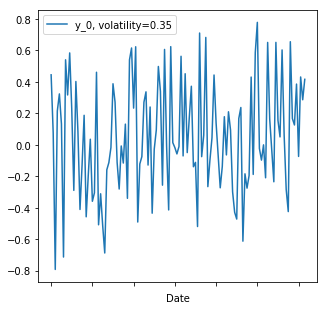

********* LSCV *******
R2_adj_train=0.9330, R2_adj_test=0.9507 for selected features: ['x_1', 'x_127', 'x_17', 'x_339', 'x_179']
with weights: [ 0.69539309  0.19520515  0.26812805 -0.12845125  0.09394845]


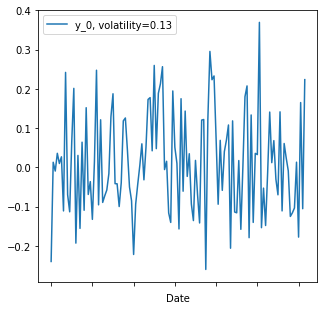

********* LSIC *******
R2_adj_train=0.9300, R2_adj_test=0.9301 for selected features: ['x_1', 'x_17', 'x_127', 'x_273']
with weights: [ 0.76198806  0.2738713   0.24726673 -0.29672521]


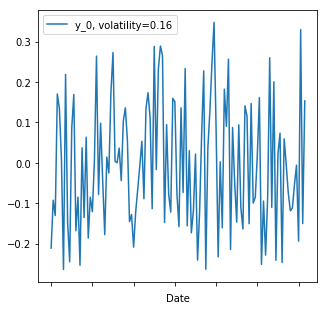

********* ENSM *******
R2_adj_train=0.8329, R2_adj_test=0.8143 for selected features: ['x_6', 'x_1', 'x_235', 'x_179', 'x_43']
with weights: [-0.08634487  0.19349803  0.47669904 -0.19306738 -0.03026571]


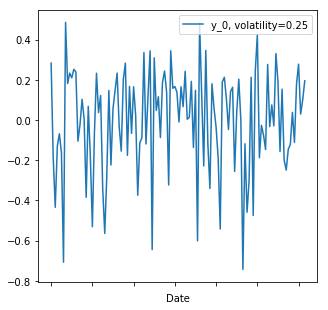

y_1
********* LS *******
R2_adj_train=0.9260, R2_adj_test=0.9239 for selected features: ['x_2', 'x_347', 'x_343', 'x_7', 'x_14']
with weights: [-0.11588577  1.03530102  0.2784771   0.30681017  0.33818245]


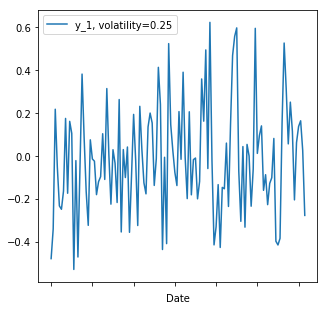

********* LSCV *******
R2_adj_train=0.9570, R2_adj_test=0.9285 for selected features: ['x_0', 'x_14', 'x_18', 'x_93', 'x_137']
with weights: [0.75423445 0.2987092  0.06142184 1.35383314 0.13857206]


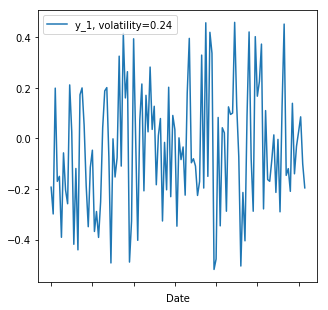

********* LSIC *******
R2_adj_train=0.9584, R2_adj_test=0.9346 for selected features: ['x_93', 'x_0', 'x_14', 'x_279', 'x_137']
with weights: [1.15224357 0.69968141 0.27218731 0.55353253 0.20026855]


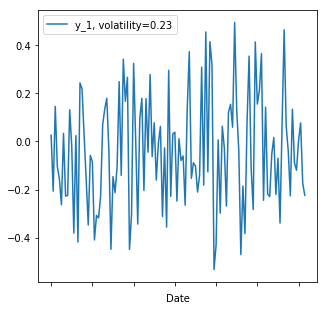

********* ENSM *******
R2_adj_train=0.9567, R2_adj_test=0.9299 for selected features: ['x_2', 'x_14', 'x_68', 'x_0', 'x_93']
with weights: [-0.01788612  0.25422107  0.16818716  0.74854168  1.17638024]


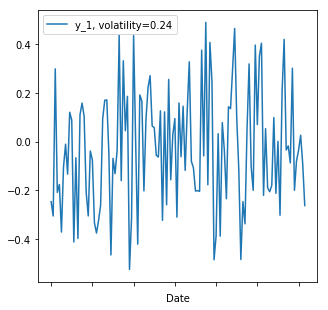

y_2
********* LS *******
R2_adj_train=0.8878, R2_adj_test=0.8310 for selected features: ['x_343', 'x_326', 'x_7', 'x_18', 'x_21']
with weights: [ 0.06721615  0.12603584  0.10072863 -0.03251837  0.06960481]


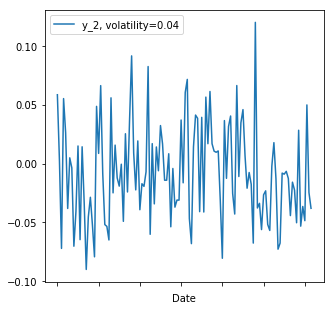

********* LSCV *******
R2_adj_train=0.8614, R2_adj_test=0.8219 for selected features: ['x_167', 'x_314', 'x_21', 'x_273', 'x_326']
with weights: [ 0.21262821  0.306627    0.10133145 -0.06802926  0.12943409]


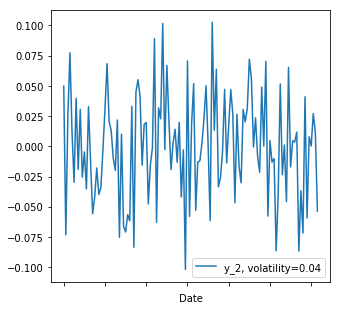

********* LSIC *******
R2_adj_train=0.9150, R2_adj_test=0.8587 for selected features: ['x_7', 'x_343', 'x_0', 'x_21', 'x_174']
with weights: [0.04158634 0.04585141 0.06500284 0.03539192 0.05277527]


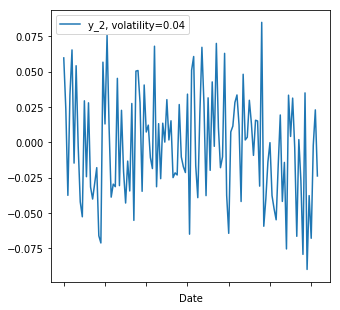

********* ENSM *******
R2_adj_train=0.9057, R2_adj_test=0.8523 for selected features: ['x_7', 'x_68', 'x_77', 'x_174', 'x_343']
with weights: [ 0.06556455  0.0392157  -0.01130792  0.05190895  0.05599427]


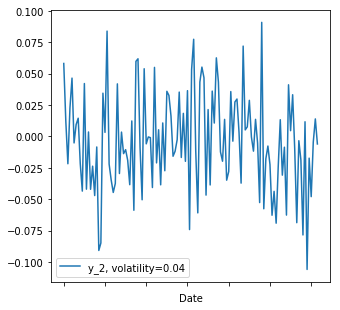

y_3
********* LS *******
R2_adj_train=0.8225, R2_adj_test=0.7752 for selected features: ['x_2', 'x_6', 'x_354', 'x_347', 'x_7']
with weights: [-0.03349335 -0.02322964  0.27479469  0.10576116  0.06160182]


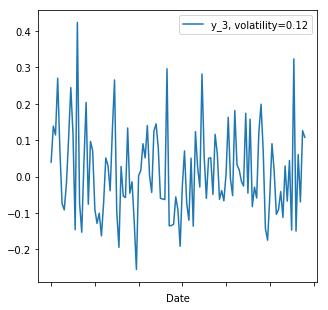

********* LSCV *******
R2_adj_train=0.8733, R2_adj_test=0.8057 for selected features: ['x_247', 'x_343', 'x_79', 'x_354', 'x_179']
with weights: [0.16018749 0.19018297 0.02731963 0.18932788 0.1398538 ]


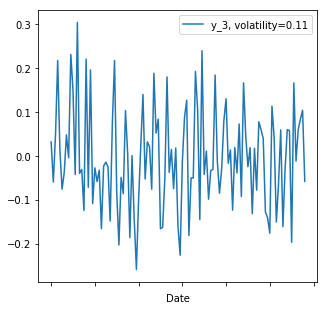

********* LSIC *******
R2_adj_train=0.8546, R2_adj_test=0.7253 for selected features: ['x_253', 'x_247', 'x_354', 'x_93', 'x_343']
with weights: [0.37591827 0.05467702 0.14063208 0.22351292 0.33494779]


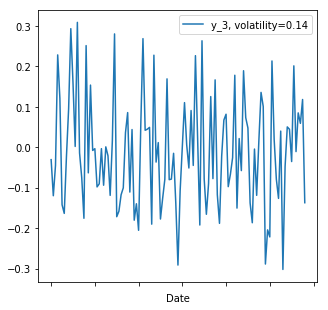

********* ENSM *******
R2_adj_train=0.8513, R2_adj_test=0.7325 for selected features: ['x_343', 'x_2', 'x_68', 'x_79']
with weights: [ 0.46951101 -0.02663055  0.06470978 -0.14907746]


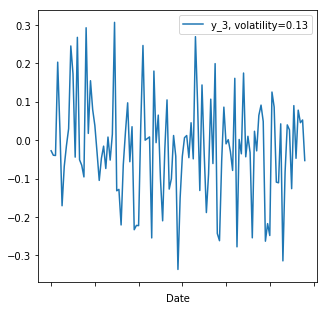

In [13]:
if __name__ == '__main__':
    
    train_ratio = 0.5
    n_best = 20
    n_limit = 5
    test_selectors = ['LS', 'LSCV', 'LSIC', 'ENSM']
    selectors = {'LS':   lasso_selector, 
                 'LSCV': lassocv_selector,
                 'LSIC': lassoIC_selector,
                 'ENSM': ensemble_selector                   
    }
    
    drop_corr_in_x(x, cutoff=0.9)
    #set_trace()    
    for target in y.columns:
        y_col = y[target]
        x_d = x.drop(y_col[y_col.isnull()].index.values)
        y_d = y_col.dropna()
        
        #split train and test data
        x_train, x_test, y_train, y_test = train_test_split(x_d, y_d, train_size=train_ratio, test_size=1-train_ratio)
        
        #use pre_selector to reduce the number of features to n_best
        sel = pre_selector(x_train, y_train, n_best)
        x_train_pre = sel.transform(x_train)
        x_test_pre = sel.transform(x_test)
        features_pre = x_test.columns[sel.get_support()]
        
        print(target)
        #evaluate different models of selectors
        for tsel in test_selectors:
            print('********* %s *******'%tsel)
            start_time = time.time()
            selector = selectors[tsel](x_train_pre, y_train)
            elapsed_T = time.time() - start_time
            
            if hasattr(selector,'coef_'):
                sorted_col = np.argsort(abs(selector.coef_))
            else:
                sorted_col = np.argsort(abs(selector.feature_importances_))
            
            features=[]
            scores_train=[]
            scores_test=[]
            posit=[]
            volat=[]
            weights=[]
            
            for i in range(1, n_limit+1):
                selected_col = sorted_col[:(-i-1):-1]
                x_train_selected = x_train_pre[:, selected_col]
                x_test_selected = x_test_pre[:, selected_col]
            
                linear = linear_model.LinearRegression()
                linear.fit(x_train_selected, y_train)     
                weights.append(linear.coef_)
                y_predict = linear.predict(x_test_selected)
            
                r2 = linear.score(x_train_selected, y_train)
                n = x_train_selected.shape[0]
                r2_adj_train = 1 - (1-r2)*(n-1)/(n-i-1)
                
                r2 = linear.score(x_test_selected, y_test)
                n = x_test_selected.shape[0]
                r2_adj_test = 1 - (1-r2)*(n-1)/(n-i-1)
                
                features.append(features_pre[selected_col])
                scores_train.append(r2_adj_train)
                scores_test.append(r2_adj_test)
                
                #calculate daily position and volatility
                posit.append(y_test-y_predict)
                volat.append((y_test-y_predict).std())
                
            result = zip(scores_train, scores_test, features, posit, volat, weights)
            result = [(s_tr, s_te, f, p, v, w) for s_tr, s_te, f, p, v, w in sorted(result, key=lambda x:x[0])]
            
            print('R2_adj_train=%.4f, R2_adj_test=%.4f for selected features:'%tuple(result[-1][0:2]), list(result[-1][2]))
            print('with weights:', result[-1][5])
            plt.figure(figsize=(5,5))
            result[-1][3].plot(label=target+', volatility=%.2f'%result[-1][4])
            plt.legend()
            plt.show()
                                               

                
    